Title

Introduction 

Methods & Results

In [4]:
# loading necessary libraries 
library(tidyverse)
library(repr)
library(tidymodels)

In [5]:
# loading the data from a url and modifying the double Outcome to become a factor datatype 
diabetes <- read_csv("https://raw.githubusercontent.com/kzhang1223/dsci-100-2023s1-group-55/main/diabetes.csv") |>
        mutate(Outcome = as_factor(Outcome)) 
head(diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [6]:
# selecting only the columns we will use for the data analysis, which are blood pressure, BMI and the diagnosis
diabetes_clean <- diabetes |>
    select(BloodPressure, BMI, Outcome) 

# removing any zeroes from the blood pressure and BMI column as they represent missing data 
diabetes_no_zeroes <- diabetes_clean |>
    filter(BloodPressure != 0 & BMI != 0) 
head(diabetes_no_zeroes)

BloodPressure,BMI,Outcome
<dbl>,<dbl>,<fct>
72,33.6,1
66,26.6,0
64,23.3,1
66,28.1,0
40,43.1,1
74,25.6,0


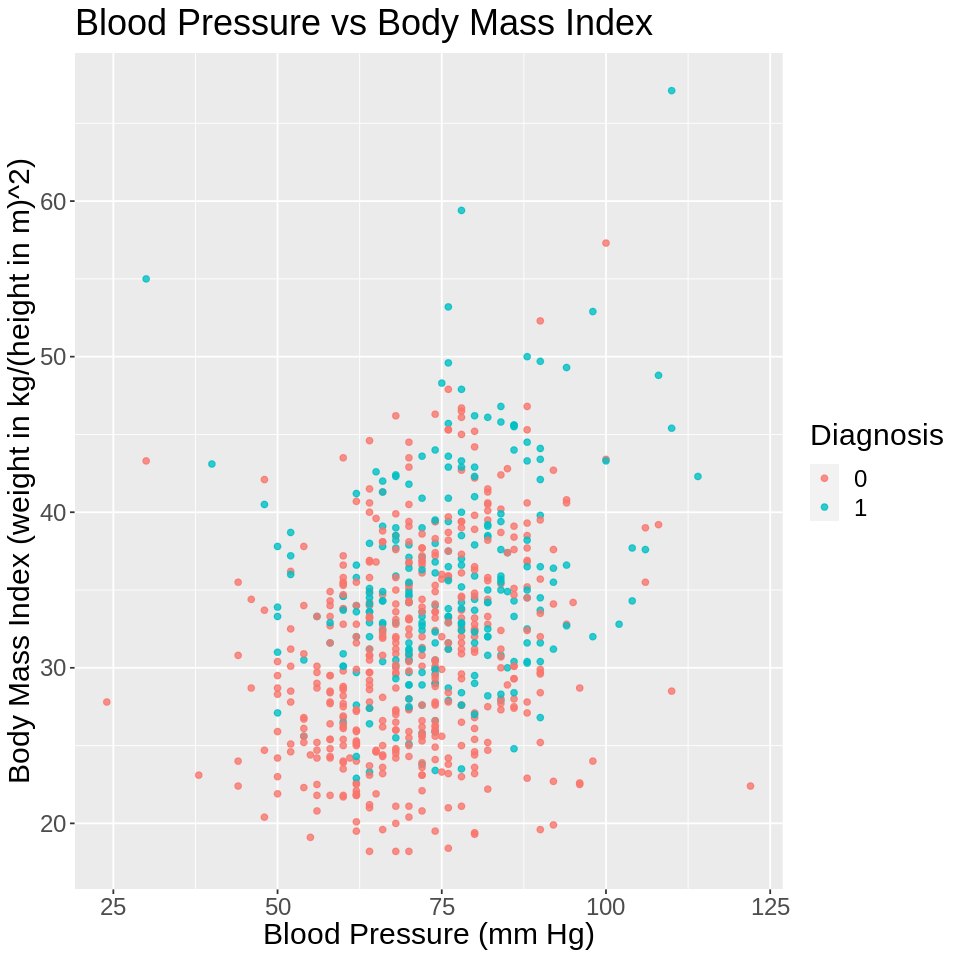

In [7]:
# creating a scatterplot of blood pressure vs BMI with all the data, colouring by the diagnosis of type 2 diabetes
options(repr.plot.width = 8, repr.plot.height = 8)

diabetes_plot <- diabetes_no_zeroes |>
    ggplot(aes(x = BloodPressure, y = BMI, colour = Outcome)) +
    geom_point(alpha = 0.8) +
    labs(x = "Blood Pressure (mm Hg)", y = "Body Mass Index (weight in kg/(height in m)^2)", color = "Diagnosis") +
    theme(text = element_text(size = 18)) + 
    ggtitle("Blood Pressure vs Body Mass Index") + 
    scale_fill_brewer(palette = 'Set2')

diabetes_plot

In [23]:
# setting the seed 
set.seed(5) 

# splitting the data into training and testing sets where 75% of the data goes into the training set 
diabetes_split <- initial_split(diabetes_no_zeroes, prop = 0.75, strata = Outcome)
diabetes_training <- training(diabetes_split)
diabetes_testing <- testing(diabetes_split) 

# preprocessing the data and creating the recipe 

diabetes_recipe <- recipe(Outcome ~ BloodPressure + BMI, data = diabetes_training)|>
step_scale(all_predictors()) |>
step_center(all_predictors())

# setting the model specification with tune() to find the best k value for this model 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification" )

# creating the cross validation sets 

diabetes_vfold <- vfold_cv(diabetes_training, v = 5, strata = Outcome)


# creating the values of k we will use 

kvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

# fitting the model to the validation sets 

diabetes_fit <- workflow() |>
add_recipe(diabetes_recipe)|>
add_model(knn_spec) |>
tune_grid(resamples = diabetes_vfold, grid = kvals) |>
collect_metrics()

accuracies <- diabetes_fit |>
filter(.metric == "accuracy")


# plotting the results to determine the best k value 

Discussion 

References